# Synthea COVID-19 Module Analysis

This notebook provides and analysis of data generated by [Synthea](https://synthetichealth.github.io/synthea/)'s COVID-19 module. Analysis is run on the CSV output from Synthea.

Code in this notebook depends on [Pandas](https://pandas.pydata.org/), [NumPy](https://numpy.org/), [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime

In [2]:
%matplotlib inline

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
%load_ext autoreload

In [5]:
%autoreload 1

This jupyter notebook evolved over the creation of the Synthea COVID-19 Module. Initially, all python code was in the notebook. Eventually, this became unwieldy and code was moved into the imported file below.

In [6]:
%aimport analysis

Read in all of the data

In [7]:
conditions = pd.read_csv("../data-set/conditions.zip", compression='zip')
patients = pd.read_csv("../data-set/patients.zip", compression='zip')
observations = pd.read_csv("../data-set/observations.zip", compression='zip')
care_plans = pd.read_csv("../data-set/careplans.zip", compression='zip')
encounters = pd.read_csv("../data-set/encounters.zip", compression='zip')
devices = pd.read_csv("../data-set/devices.zip", compression='zip')
supplies = pd.read_csv("../data-set/supplies.zip", compression='zip')
procedures = pd.read_csv("../data-set/procedures.zip", compression='zip')
medications = pd.read_csv("../data-set/medications.zip", compression='zip')
immunizations = pd.read_csv("../data-set/immunizations.zip", compression='zip')

Grab the IDs of patients that have been diagnosed with COVID-19

In [8]:
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

This grabs every patient with a negative SARS-CoV-2 test. This will include patients who tested negative up front as well as patients that tested negative after leaving the hospital

In [9]:
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()

Grabs IDs for all patients that died in the simulation. This will be more than just COVID-19 deaths.

In [10]:
deceased_patients = patients[patients.DEATHDATE.notna()].Id

Grabs IDs for patients that have completed the care plan for isolation at home.

In [11]:
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

Survivors are the union of those who have completed isolation at home or have a negative SARS-CoV-2 test.

In [12]:
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)

Grab IDs for patients with admission due to COVID-19

In [13]:
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT

The number of inpatient survivors

In [14]:
np.intersect1d(inpatient_ids, survivor_ids).shape

(325,)

The number of inpatient non-survivors

In [15]:
np.intersect1d(inpatient_ids, deceased_patients).shape

(60,)

In [16]:
inpatient_ids.shape

(384,)

## Health outcomes experienced by COVID-19 patients

The following table shows different health outcomes that were experienced by COVID-19 patients during the course of the disease. The table shows outcomes for individuals who had COVID-19 during an inpatient encounter.

The table columns are defined as follows:

* **Outcome** - A health outcome experienced by an individual during an inpatient encounter
* **Total** - The total number of patients with an inpatient encounter during which they had COVID-19 and the given health outcome
* **Percent of Inpatient** - The total number of patients with an inpatient encounter during which they had COVID-19 and the given health outcome, divided by the total number of patients with an inpatient encounter with COVID-19
* **Survivor** - The total number of patients with an inpatient encounter during which they had COVID-19 and the given health outcome and survived
* **Percent Survivors** - The total number of patients with an inpatient encounter during which they had COVID-19 and the given health outcome and survived, divided by the total number of patients with an inpatient encounter with COVID-19 who also survived
* **Non-Survivor** - The total number of patients with an inpatient encounter during which they had COVID-19 and the given health outcome and did not survive
* **Percent Non-Survivors** - The total number of patients with an inpatient encounter during which they had COVID-19 and the given health outcome and did not survive, divided by the total number of patients with an inpatient encounter with COVID-19 who also did not survive

In [17]:
analysis.outcome_table(inpatient_ids, survivor_ids, deceased_patients, conditions)

,outcome,total,percent of inpatient,survivors,percent survivors,non survivors,percent non survivors
0,Sepsis,144,0.374026,86,0.264615,58,0.966667
1,Respiratory Failure,185,0.480519,127,0.390769,58,0.966667
2,ARDS,41,0.106494,2,0.006154,39,0.650000
3,Heart Failure,23,0.059740,2,0.006154,21,0.350000
4,Septic Shock,38,0.098701,2,0.006154,36,0.600000
5,Coagulopathy,24,0.062338,3,0.009231,21,0.350000
6,Acute Cardiac Injury,17,0.044156,1,0.003077,16,0.266667
7,Acute Kidney Injury,17,0.044156,0,0.000000,17,0.283333


## Lab values for COVID-19 patients

The following code presents lab values taken for COVID-19 patients. Values are separated into survivors and non survivors.

The first block of code selects lab values of interest from all observations in the simulation.

In [18]:
lab_obs = observations[(observations.CODE == '48065-7') | (observations.CODE == '26881-3') | 
                          (observations.CODE == '2276-4') | (observations.CODE == '89579-7') |
                          (observations.CODE == '2532-0') | (observations.CODE == '731-0') |
                          (observations.CODE == '14804-9')
                      ]

Select COVID-19 conditions out of all conditions in the simulation

In [19]:
covid_conditions = conditions[conditions.CODE == 840539006]

Merge the COVID-19 conditions with the patients

In [20]:
covid_patients = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')

Add an attribute to the DataFrame indicating whether this is a survivor or not.

In [21]:
covid_patients['survivor'] = covid_patients.PATIENT.isin(survivor_ids)

Reduce the columns on the DataFrame to ones needed

In [22]:
covid_patients = covid_patients[['START', 'PATIENT', 'survivor', 'CODE']]

Calculate attributes needed to support the plot. Also coerce all lab values into a numeric data type.

In [23]:
covid_patients_obs = covid_patients.merge(lab_obs, on='PATIENT')
covid_patients_obs['START'] = pd.to_datetime(covid_patients_obs.START, utc=True)
covid_patients_obs['DATE'] = pd.to_datetime(covid_patients_obs.DATE)
covid_patients_obs['lab_days'] = covid_patients_obs.DATE - covid_patients_obs.START
covid_patients_obs['days'] = np.around(covid_patients_obs.lab_days / np.timedelta64(1, 'D'))
covid_patients_obs['VALUE'] = pd.to_numeric(covid_patients_obs['VALUE'], errors='coerce')

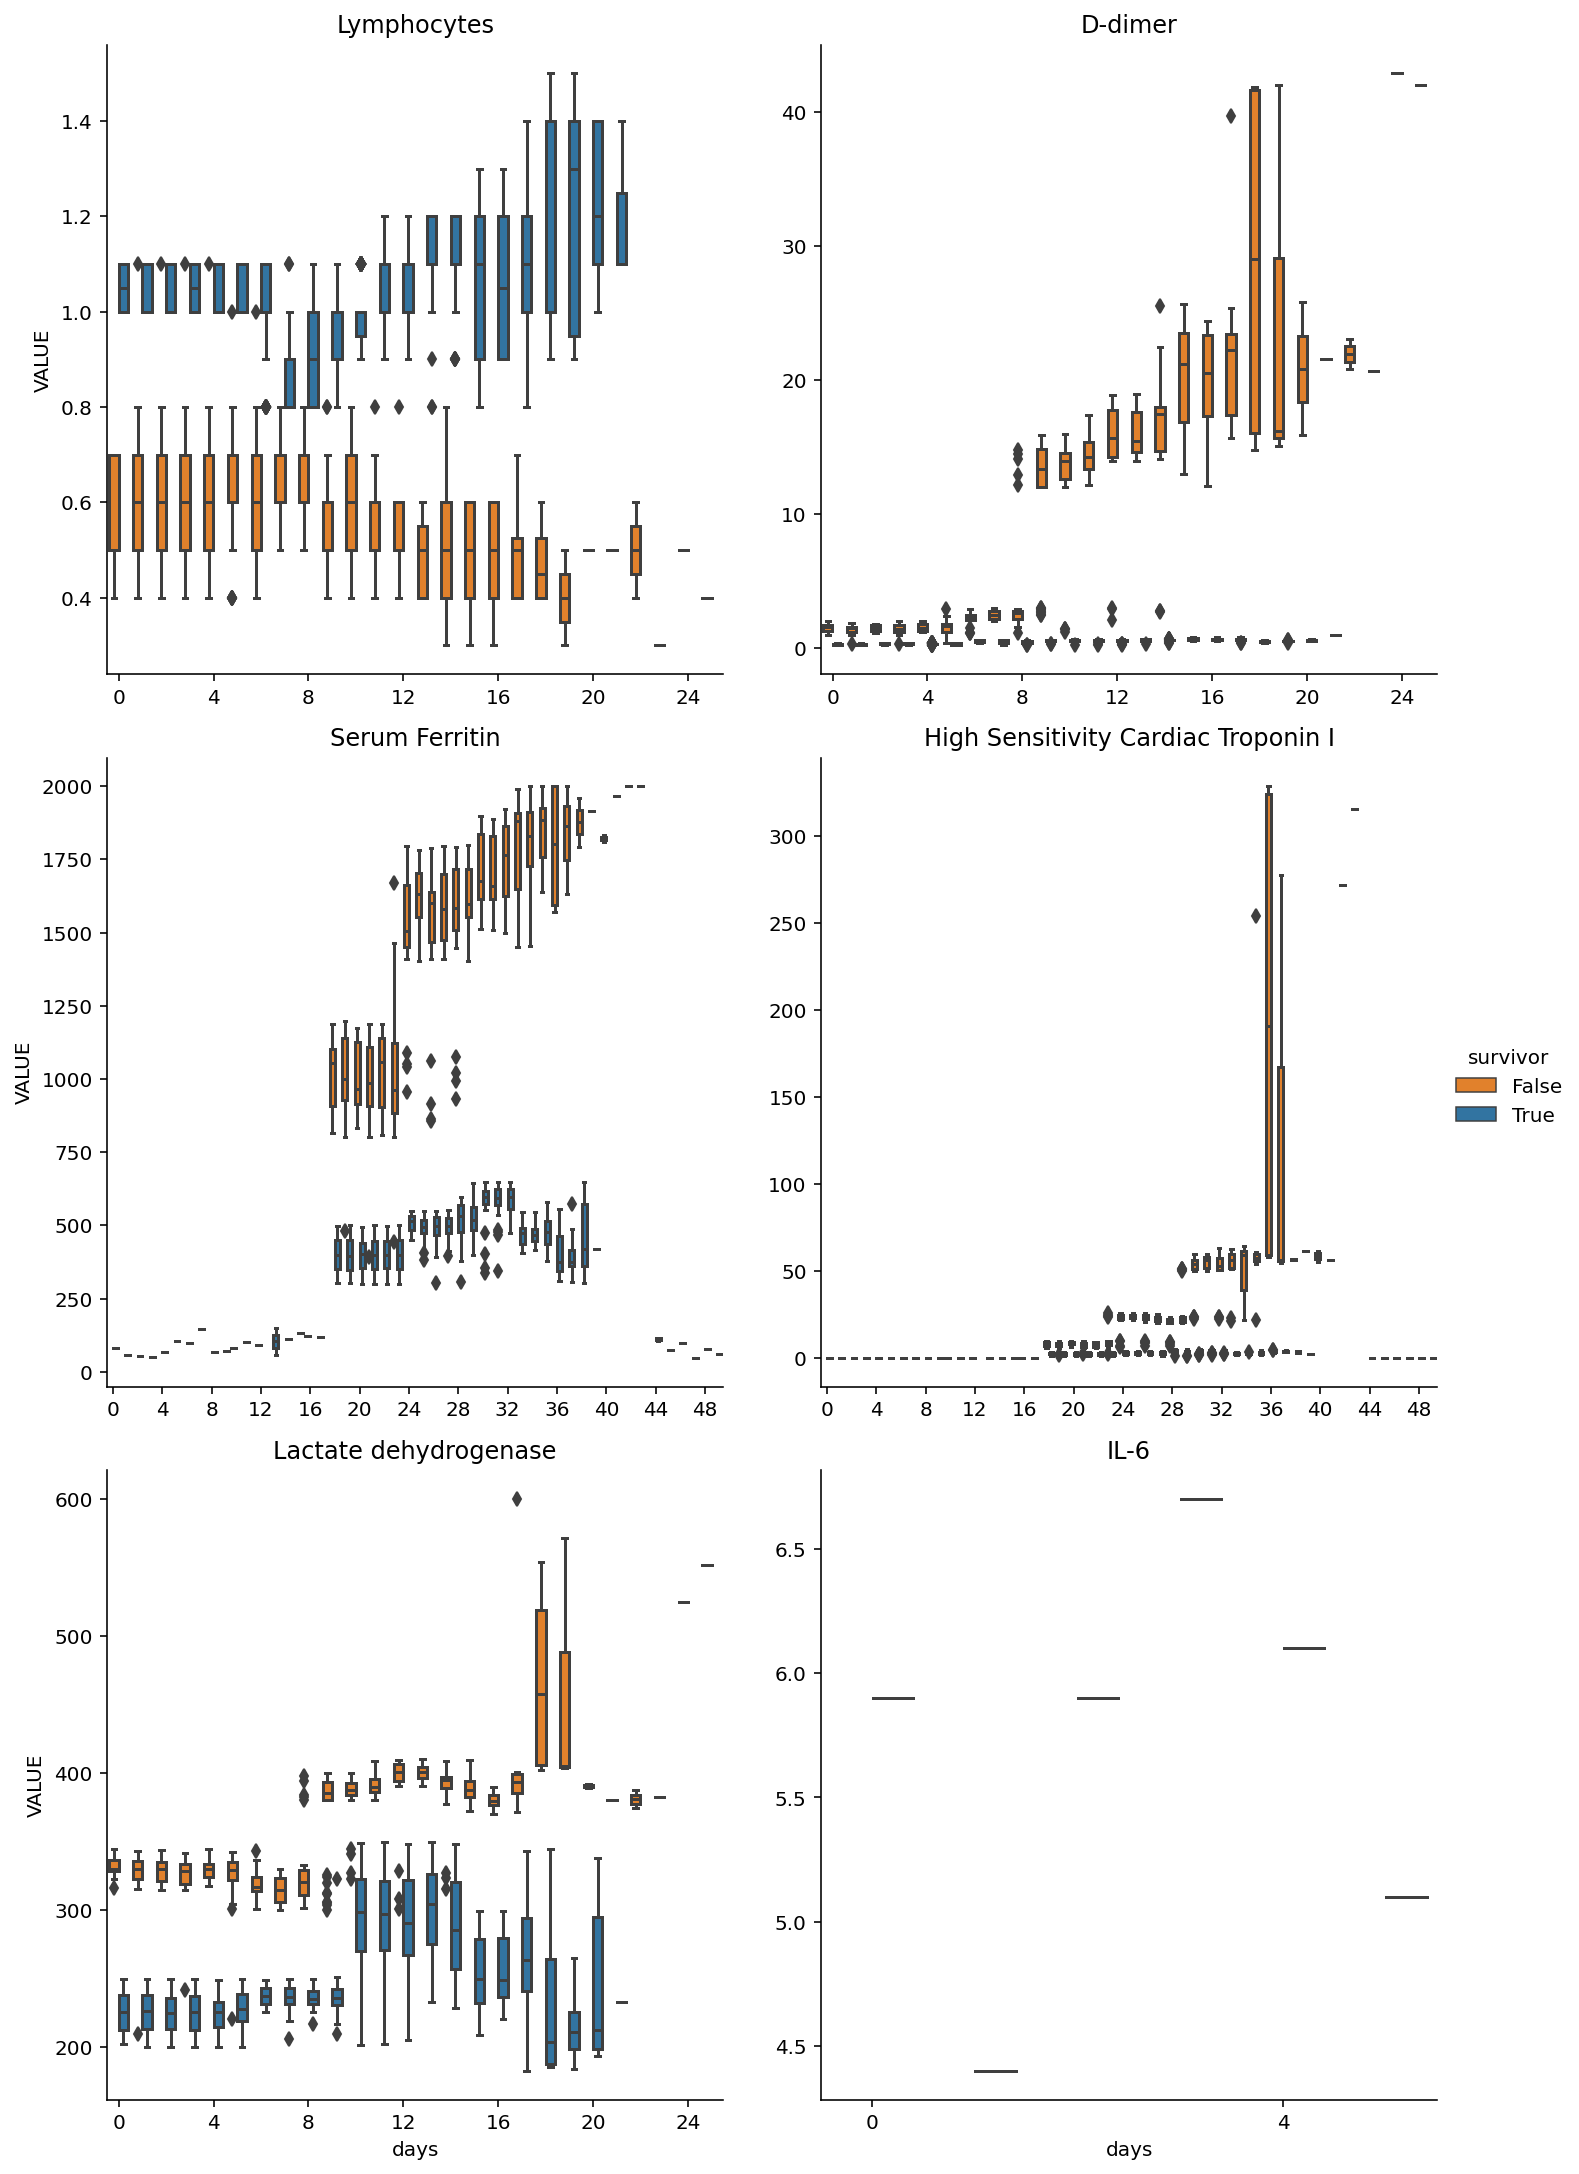

In [24]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="box", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])
        
plt.show()

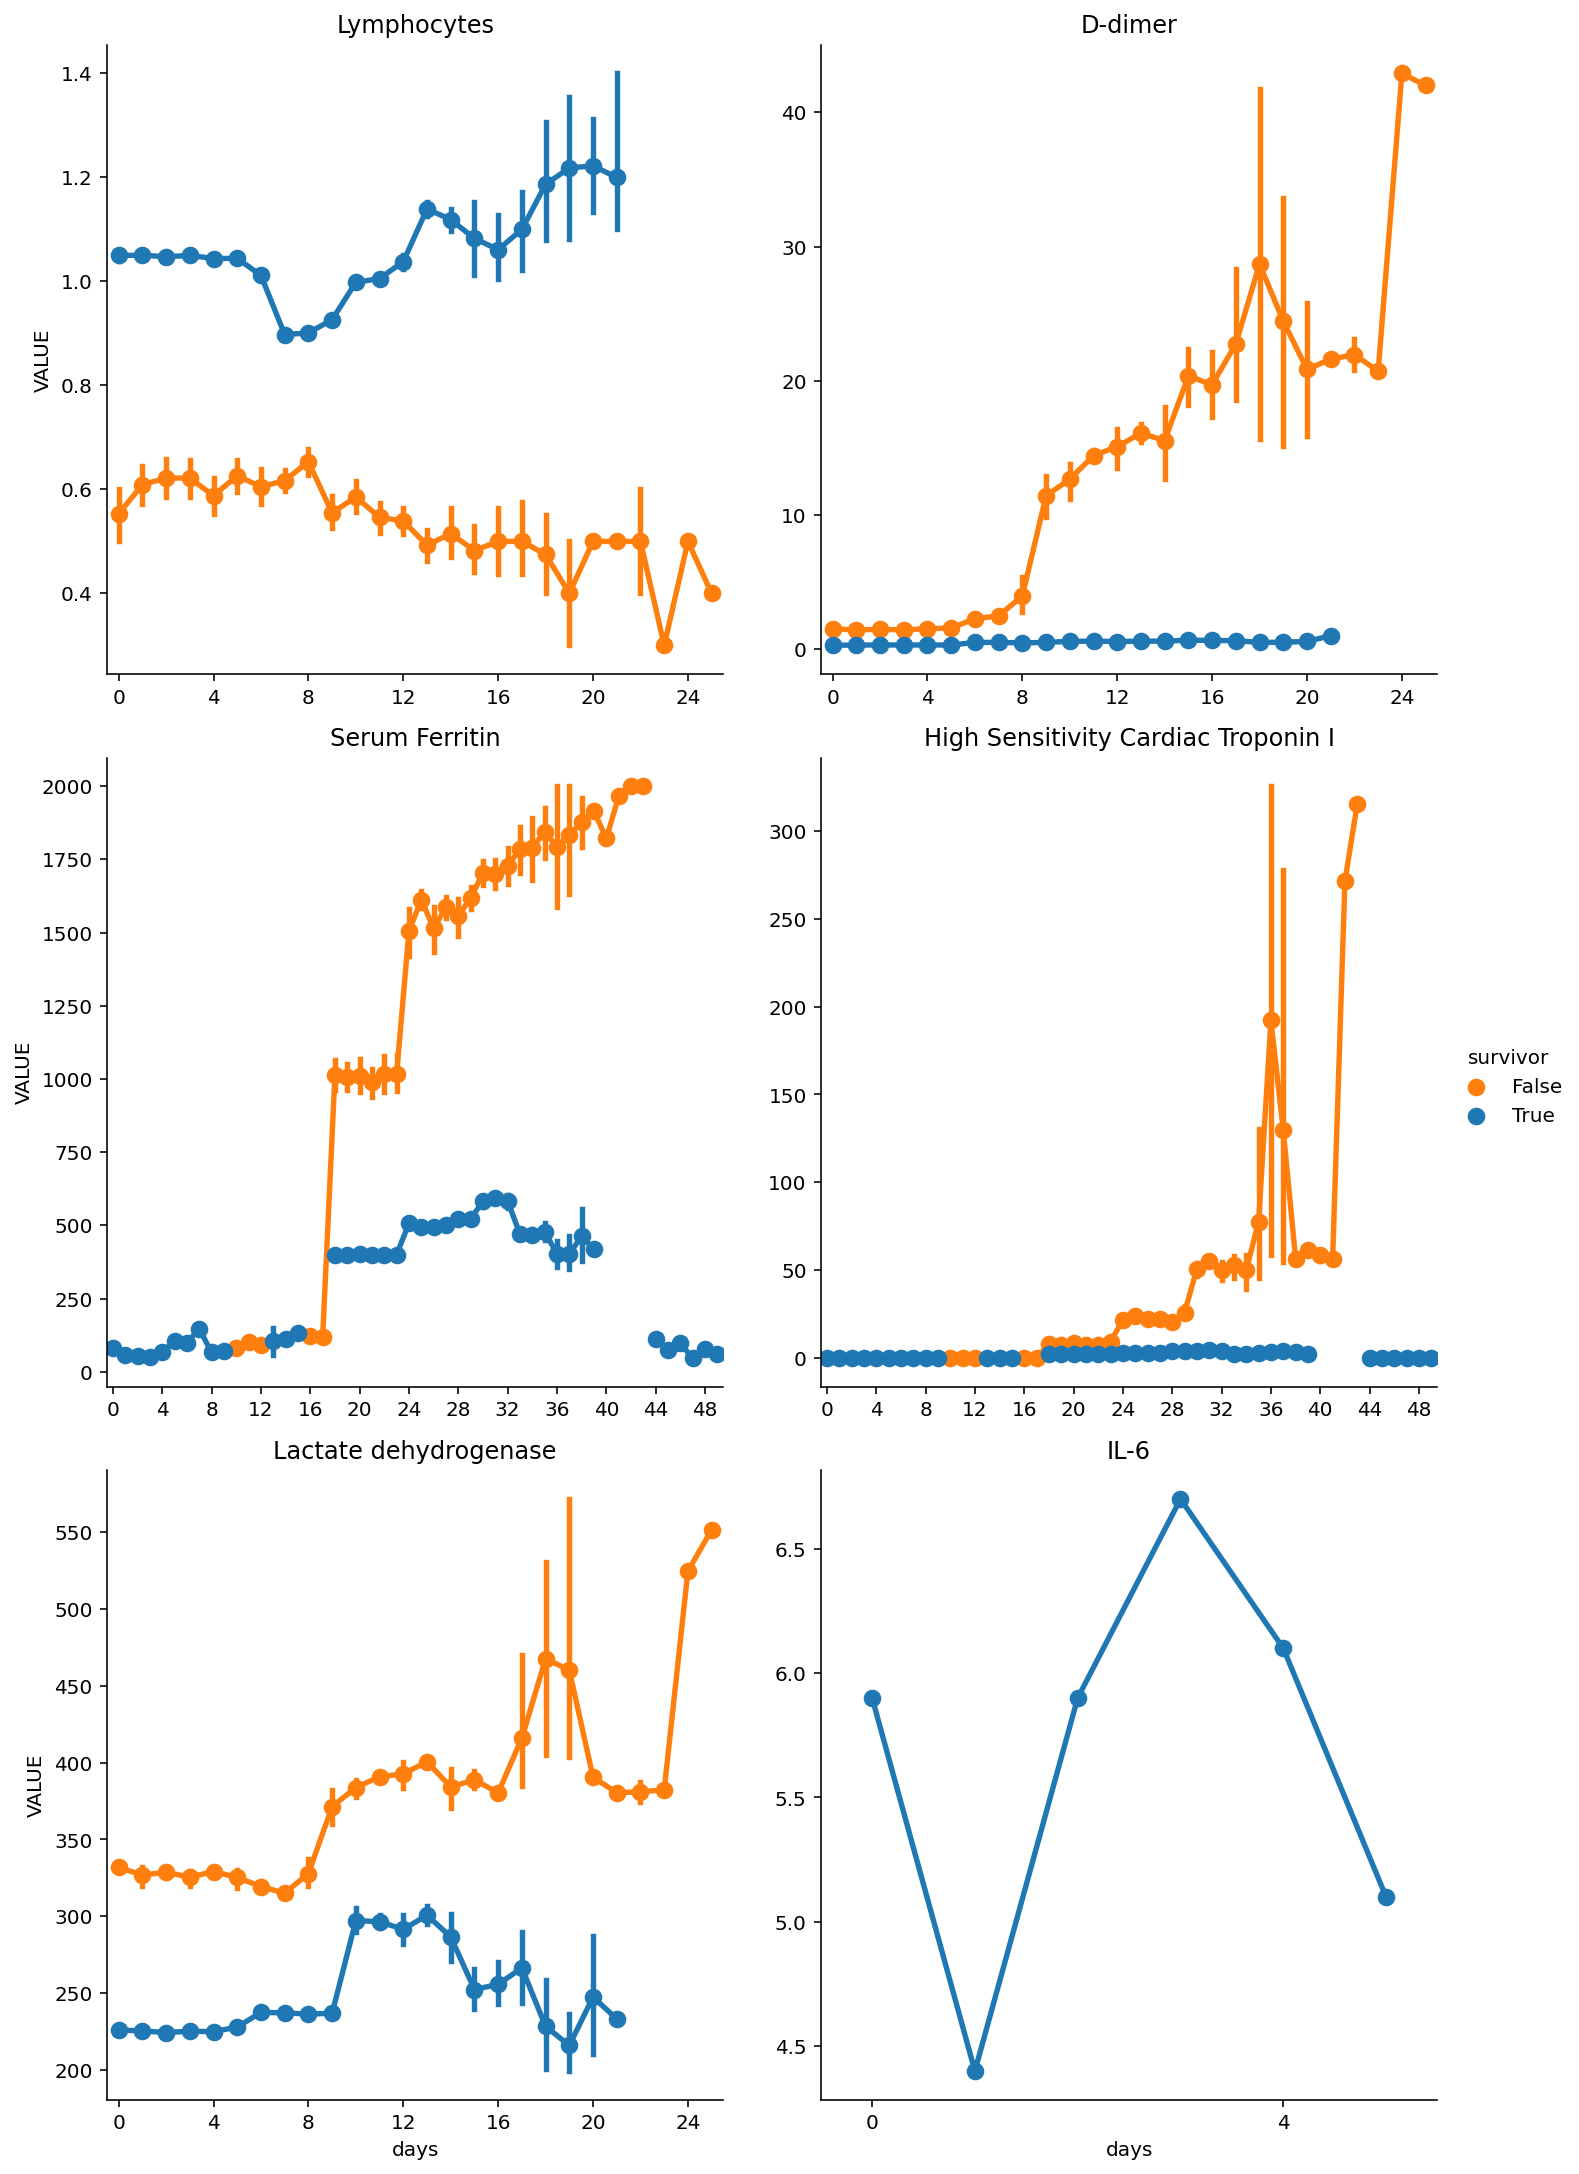

In [25]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="point", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])

plt.show()

Set up a new DataFrame with boolean columns representing various outcomes, like admit, recovery or death

In [26]:
cp = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')
isolation_ids = care_plans[(care_plans.CODE == 736376001) & (care_plans.REASONCODE == 840539006)].PATIENT
cp['isolation'] = cp.Id.isin(isolation_ids)
cp['admit'] = cp.Id.isin(inpatient_ids)
cp['recovered'] = cp.Id.isin(survivor_ids)
cp['death'] = cp.DEATHDATE.notna()
icu_ids = encounters[encounters.CODE == 305351004].PATIENT
cp['icu_admit'] = cp.Id.isin(icu_ids)
vent_ids = procedures[procedures.CODE == 26763009].PATIENT
cp['ventilated'] = cp.Id.isin(vent_ids)

## Outcomes for all COVID-19 Patients

This code builds a new DataFrame for the purposes of display. The DataFrame contains the percentages of patients that experience a particular outcome. Percentages are then provided for only hospitalized patients, ICU admitted patients and ventilated patients.

In [27]:
hospitalized = (cp.admit == True)
icu = (cp.icu_admit == True)
vent = (cp.ventilated == True)
covid_count = cp.Id.size
row_filters = {'Home Isolation': (cp.isolation == True), 'Hospital Admission': hospitalized, 'ICU Admission': icu,
 'Ventilated': vent, 'Recovered': (cp.recovered == True), 'Death': (cp.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['All Patients'] = cp[row_filter].Id.size / covid_count
    row['Hospitalized'] = cp[row_filter & hospitalized].Id.size / hospitalized.value_counts()[True]
    row['ICU Admitted'] = cp[row_filter & icu].Id.size / icu.value_counts()[True]
    row['Required Ventilation'] = cp[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,All Patients,Hospitalized,ICU Admitted,Required Ventilation
0,Home Isolation,0.812815,0.033854,0.085714,0.058824
1,Hospital Admission,0.193744,1.000000,0.957143,1.000000
2,ICU Admission,0.035318,0.174479,1.000000,1.000000
3,Ventilated,0.025732,0.132812,0.728571,1.000000
4,Recovered,0.941978,0.846354,0.371429,0.156863
5,Death,0.031786,0.156250,0.642857,0.843137


## Outcomes for ICU Admitted Patients

Essentially a sub table from above, looking only at ICU patients.

In [28]:
icu_only = cp[cp.icu_admit == True]

vent = (icu_only.ventilated == True)
covid_count = icu_only.Id.size
row_filters = {'Ventilated': vent, 'Recovered': (icu_only.recovered == True), 'Death': (icu_only.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['ICU Admitted'] = icu_only[row_filter].Id.size / covid_count
    row['Required Ventilation'] = icu_only[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,ICU Admitted,Required Ventilation
0,Ventilated,0.728571,1.000000
1,Recovered,0.371429,0.156863
2,Death,0.642857,0.843137


Start to build a DataFrame that we can use to look at other conditions in relation to COVID-19

In [29]:
covid_info = cp[['PATIENT', 'recovered', 'death', 'START', 'DEATHDATE', 'BIRTHDATE', 'GENDER', 'admit', 'icu_admit']]

In [30]:
covid_info = covid_info.rename(columns={'START': 'covid_start'})

Grab all of the conditions starting after January 20, 2020. This is a hack to get only conditions that are related to COVID-19. We will end up merging these with the COVID patients.

In [31]:
covid_related_conditions = conditions[pd.to_datetime(conditions.START) > pd.to_datetime('2020-01-20')]

This DataFrame will contain all conditions for COVID-19 patients, where `START` can be compared to `covid_start` to see how long after the COVID-19 diagnosis something happened.

In [32]:
covid_patient_conditions = covid_info.merge(covid_related_conditions, on='PATIENT')

## Symptoms for all COVID-19 Patients

Generates a DataFrame with percentages of co-occurring conditions

In [33]:
analysis.symptom_table(covid_patient_conditions)

,Symptoms,All Patients Percentage,All Patients Count,Survivor Percentage,Survivor Count,Non Survivor Percentage,Non Survivor Count
0,Conjunctival Congestion,0.007568,15,0.006963,13,0.031746,2
1,Nasal Congestion,0.048940,97,0.048741,91,0.063492,4
2,Headache,0.122603,243,0.123728,231,0.142857,9
3,Cough,0.687185,1362,0.686127,1281,0.698413,44
4,Sore Throat,0.141271,280,0.144081,269,0.063492,4
5,Sputum Production,0.344097,682,0.344403,643,0.333333,21
6,Fatigue,0.383956,761,0.381360,712,0.428571,27
7,Hemoptysis,0.012614,25,0.010712,20,0.079365,5
8,Shortness of Breath,0.199294,395,0.194965,364,0.349206,22
9,Nausea,0.039859,79,0.039636,74,0.079365,5


## Symptoms for ICU admitted COVID-19 Patients

DataFrame limited to individuals admitted to the ICU

In [34]:
analysis.symptom_table(covid_patient_conditions, True)

,Symptoms,All Patients Percentage,All Patients Count,Survivor Percentage,Survivor Count,Non Survivor Percentage,Non Survivor Count
0,Conjunctival Congestion,0.028571,2,0.000000,0,0.044444,2
1,Nasal Congestion,0.042857,3,0.000000,0,0.066667,3
2,Headache,0.128571,9,0.115385,3,0.133333,6
3,Cough,0.728571,51,0.730769,19,0.733333,33
4,Sore Throat,0.100000,7,0.115385,3,0.088889,4
5,Sputum Production,0.371429,26,0.384615,10,0.355556,16
6,Fatigue,0.442857,31,0.500000,13,0.422222,19
7,Hemoptysis,0.042857,3,0.000000,0,0.066667,3
8,Shortness of Breath,0.357143,25,0.269231,7,0.400000,18
9,Nausea,0.071429,5,0.038462,1,0.088889,4


Create a DataFrame with columns that show a condition's start and end in days relative to COVID-19 diagnosis. Also create a column that calculates the number of days between COVID-19 diagnosis and a person's death.

In [35]:
covid_patient_conditions['start_days'] = (pd.to_datetime(covid_patient_conditions.START) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['end_days'] = (pd.to_datetime(covid_patient_conditions.STOP) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['death_days'] = (pd.to_datetime(covid_patient_conditions.DEATHDATE) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')

## Timelines for hospitalized patients

These plots show the progression of COVID-19 related complications in hospitalized patients. The bars represent the average start and end time for the particular item. Arrows at the bottom show the time or start time of a particular item.

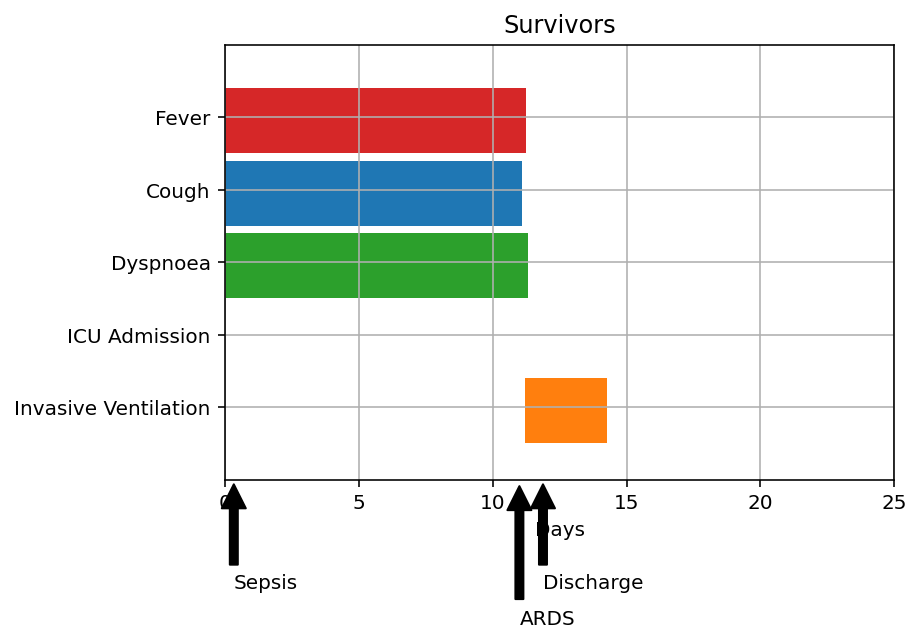

In [36]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.recovered == True) &
                                                               (covid_patient_conditions.admit == True)))
analysis.survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

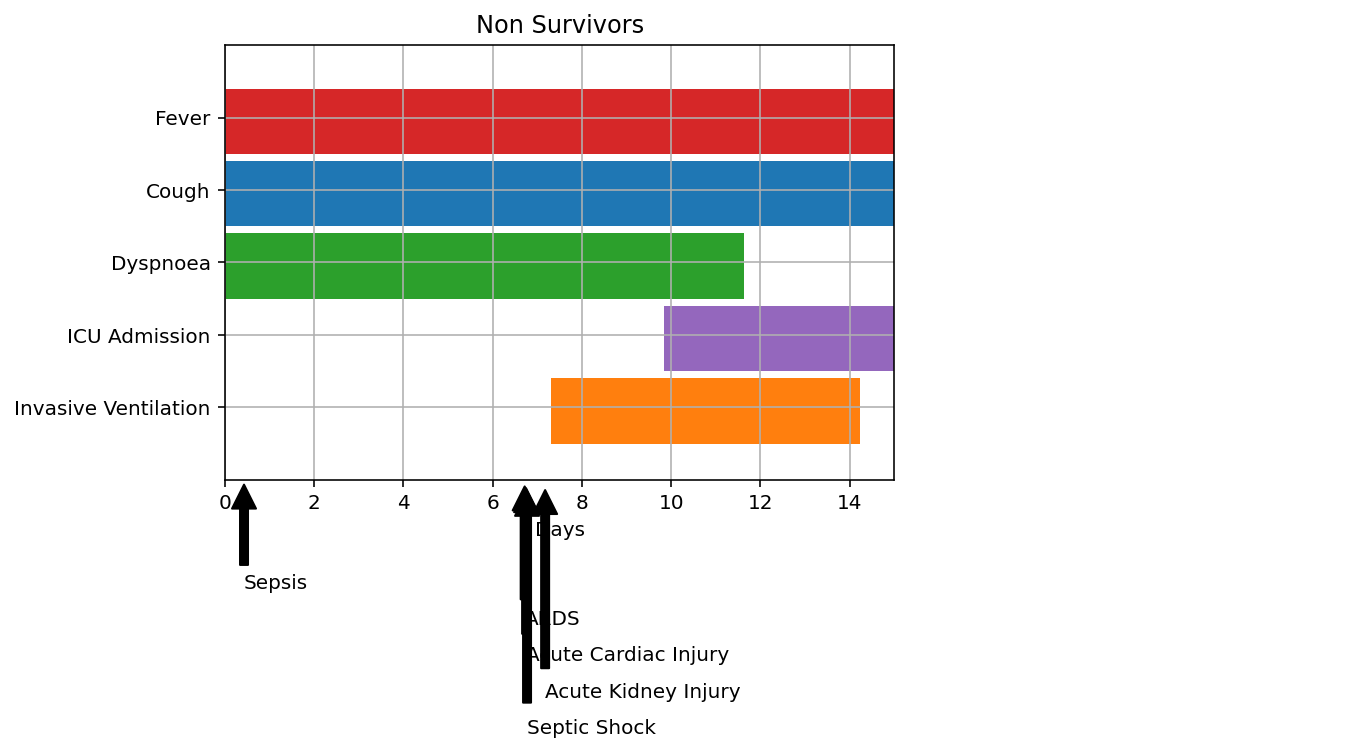

In [37]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.death == True) &
                                                               (covid_patient_conditions.admit == True)))
analysis.non_survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

## Timelines for ICU only patients

These plots refine the timelines to only patients with ICU admissions

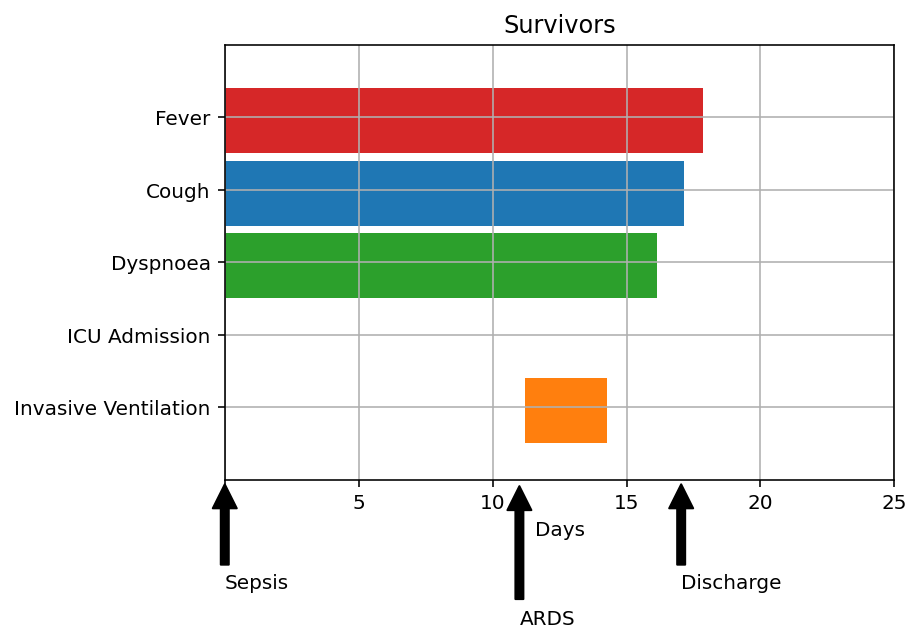

In [38]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.recovered == True) &
                                                               (covid_patient_conditions.icu_admit == True)))
analysis.survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info, True)

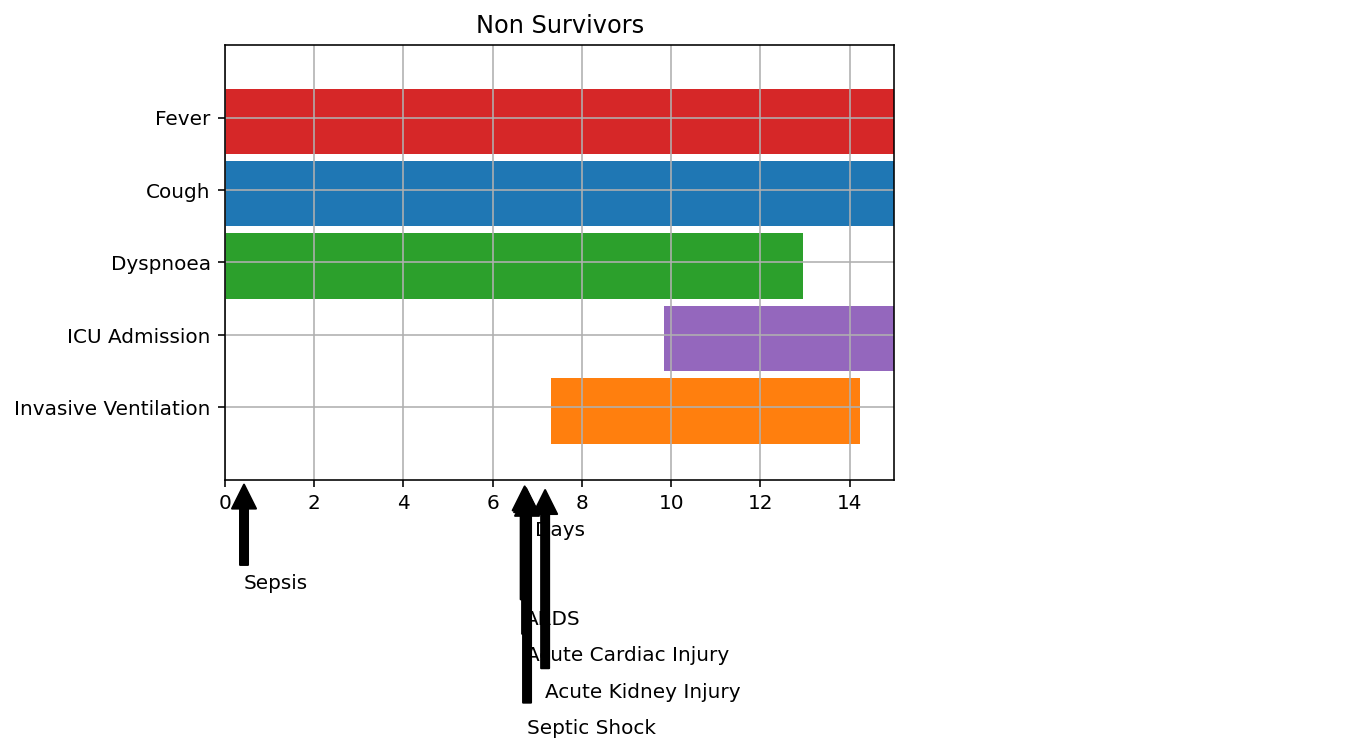

In [39]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.death == True) &
                                                               (covid_patient_conditions.icu_admit == True)))
analysis.non_survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

Add an age column to the DataFrame for rows where the patient has died

In [40]:
covid_info.loc[covid_info.death == True, 'age'] = (pd.to_datetime(covid_info.DEATHDATE) - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

Populate ages for survivors based on the current date

In [41]:
covid_info.loc[covid_info.recovered == True, 'age'] = (datetime.datetime.now() - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

Create an age_range column that places individuals into 10 year age ranges, such as 0 - 10, 10 - 20, etc.

In [42]:
bins = list(range(0, 120, 10))
covid_info['age_range'] = pd.cut(covid_info.age, bins=bins)

## Mortality by Age and Sex

A plot of deaths grouped by age range and gender.

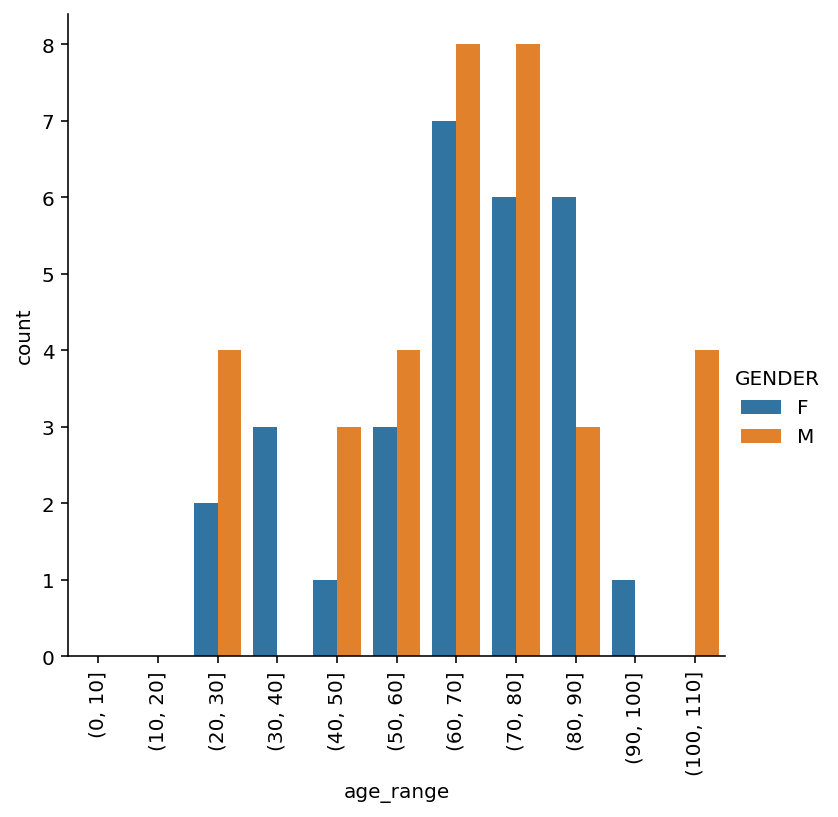

In [43]:
chart = sns.catplot(x="age_range", kind="count", hue="GENDER", data=covid_info[covid_info.death==True]);
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

A table view of the same information from above

In [44]:
covid_info[covid_info.death==True].groupby(['age_range', 'GENDER']).count()[['PATIENT']]

PATIENT
age_range  GENDER         
(0, 10]    F           NaN
           M           NaN
(10, 20]   F           NaN
           M           NaN
(20, 30]   F           2.0
           M           4.0
(30, 40]   F           3.0
           M           NaN
(40, 50]   F           1.0
           M           3.0
(50, 60]   F           3.0
           M           4.0
(60, 70]   F           7.0
           M           8.0
(70, 80]   F           6.0
           M           8.0
(80, 90]   F           6.0
           M           3.0
(90, 100]  F           1.0
           M           NaN
(100, 110] F           NaN
           M           4.0

Another table view of the mortality data, this time just grouped by age range

In [45]:
covid_info[covid_info.death==True].groupby(['age_range']).count()[['PATIENT']]

,PATIENT
age_range,
"(0, 10]",0
"(10, 20]",0
"(20, 30]",6
"(30, 40]",3
"(40, 50]",4
"(50, 60]",7
"(60, 70]",15
"(70, 80]",14
"(80, 90]",9


Build a DataFrame that shows the total count of a supply used on a given day

In [46]:
grouped_supplies = supplies.groupby(['DESCRIPTION', 'DATE']).sum()

Finally, the following table shows the case fatality rate (CFR). This is calculated as the number of non survivors over the number of individuals who have had COVID-19 in the population, by age range.

In [47]:
ci_sums = covid_info.groupby(['age_range', 'GENDER']).agg("sum")
ci_sums['cfr'] = ci_sums.death / (ci_sums.recovered + ci_sums.death)
ci_sums[['cfr']]

cfr
age_range  GENDER          
(0, 10]    F       0.000000
           M       0.000000
(10, 20]   F       0.000000
           M       0.000000
(20, 30]   F       0.012821
           M       0.028369
(30, 40]   F       0.020548
           M       0.000000
(40, 50]   F       0.008475
           M       0.025210
(50, 60]   F       0.021277
           M       0.028571
(60, 70]   F       0.066667
           M       0.080000
(70, 80]   F       0.100000
           M       0.148148
(80, 90]   F       0.260870
           M       0.125000
(90, 100]  F       0.166667
           M       0.000000
(100, 110] F       0.000000
           M       0.363636

## Supply Usage

Small multiples plot of supply usage over time.

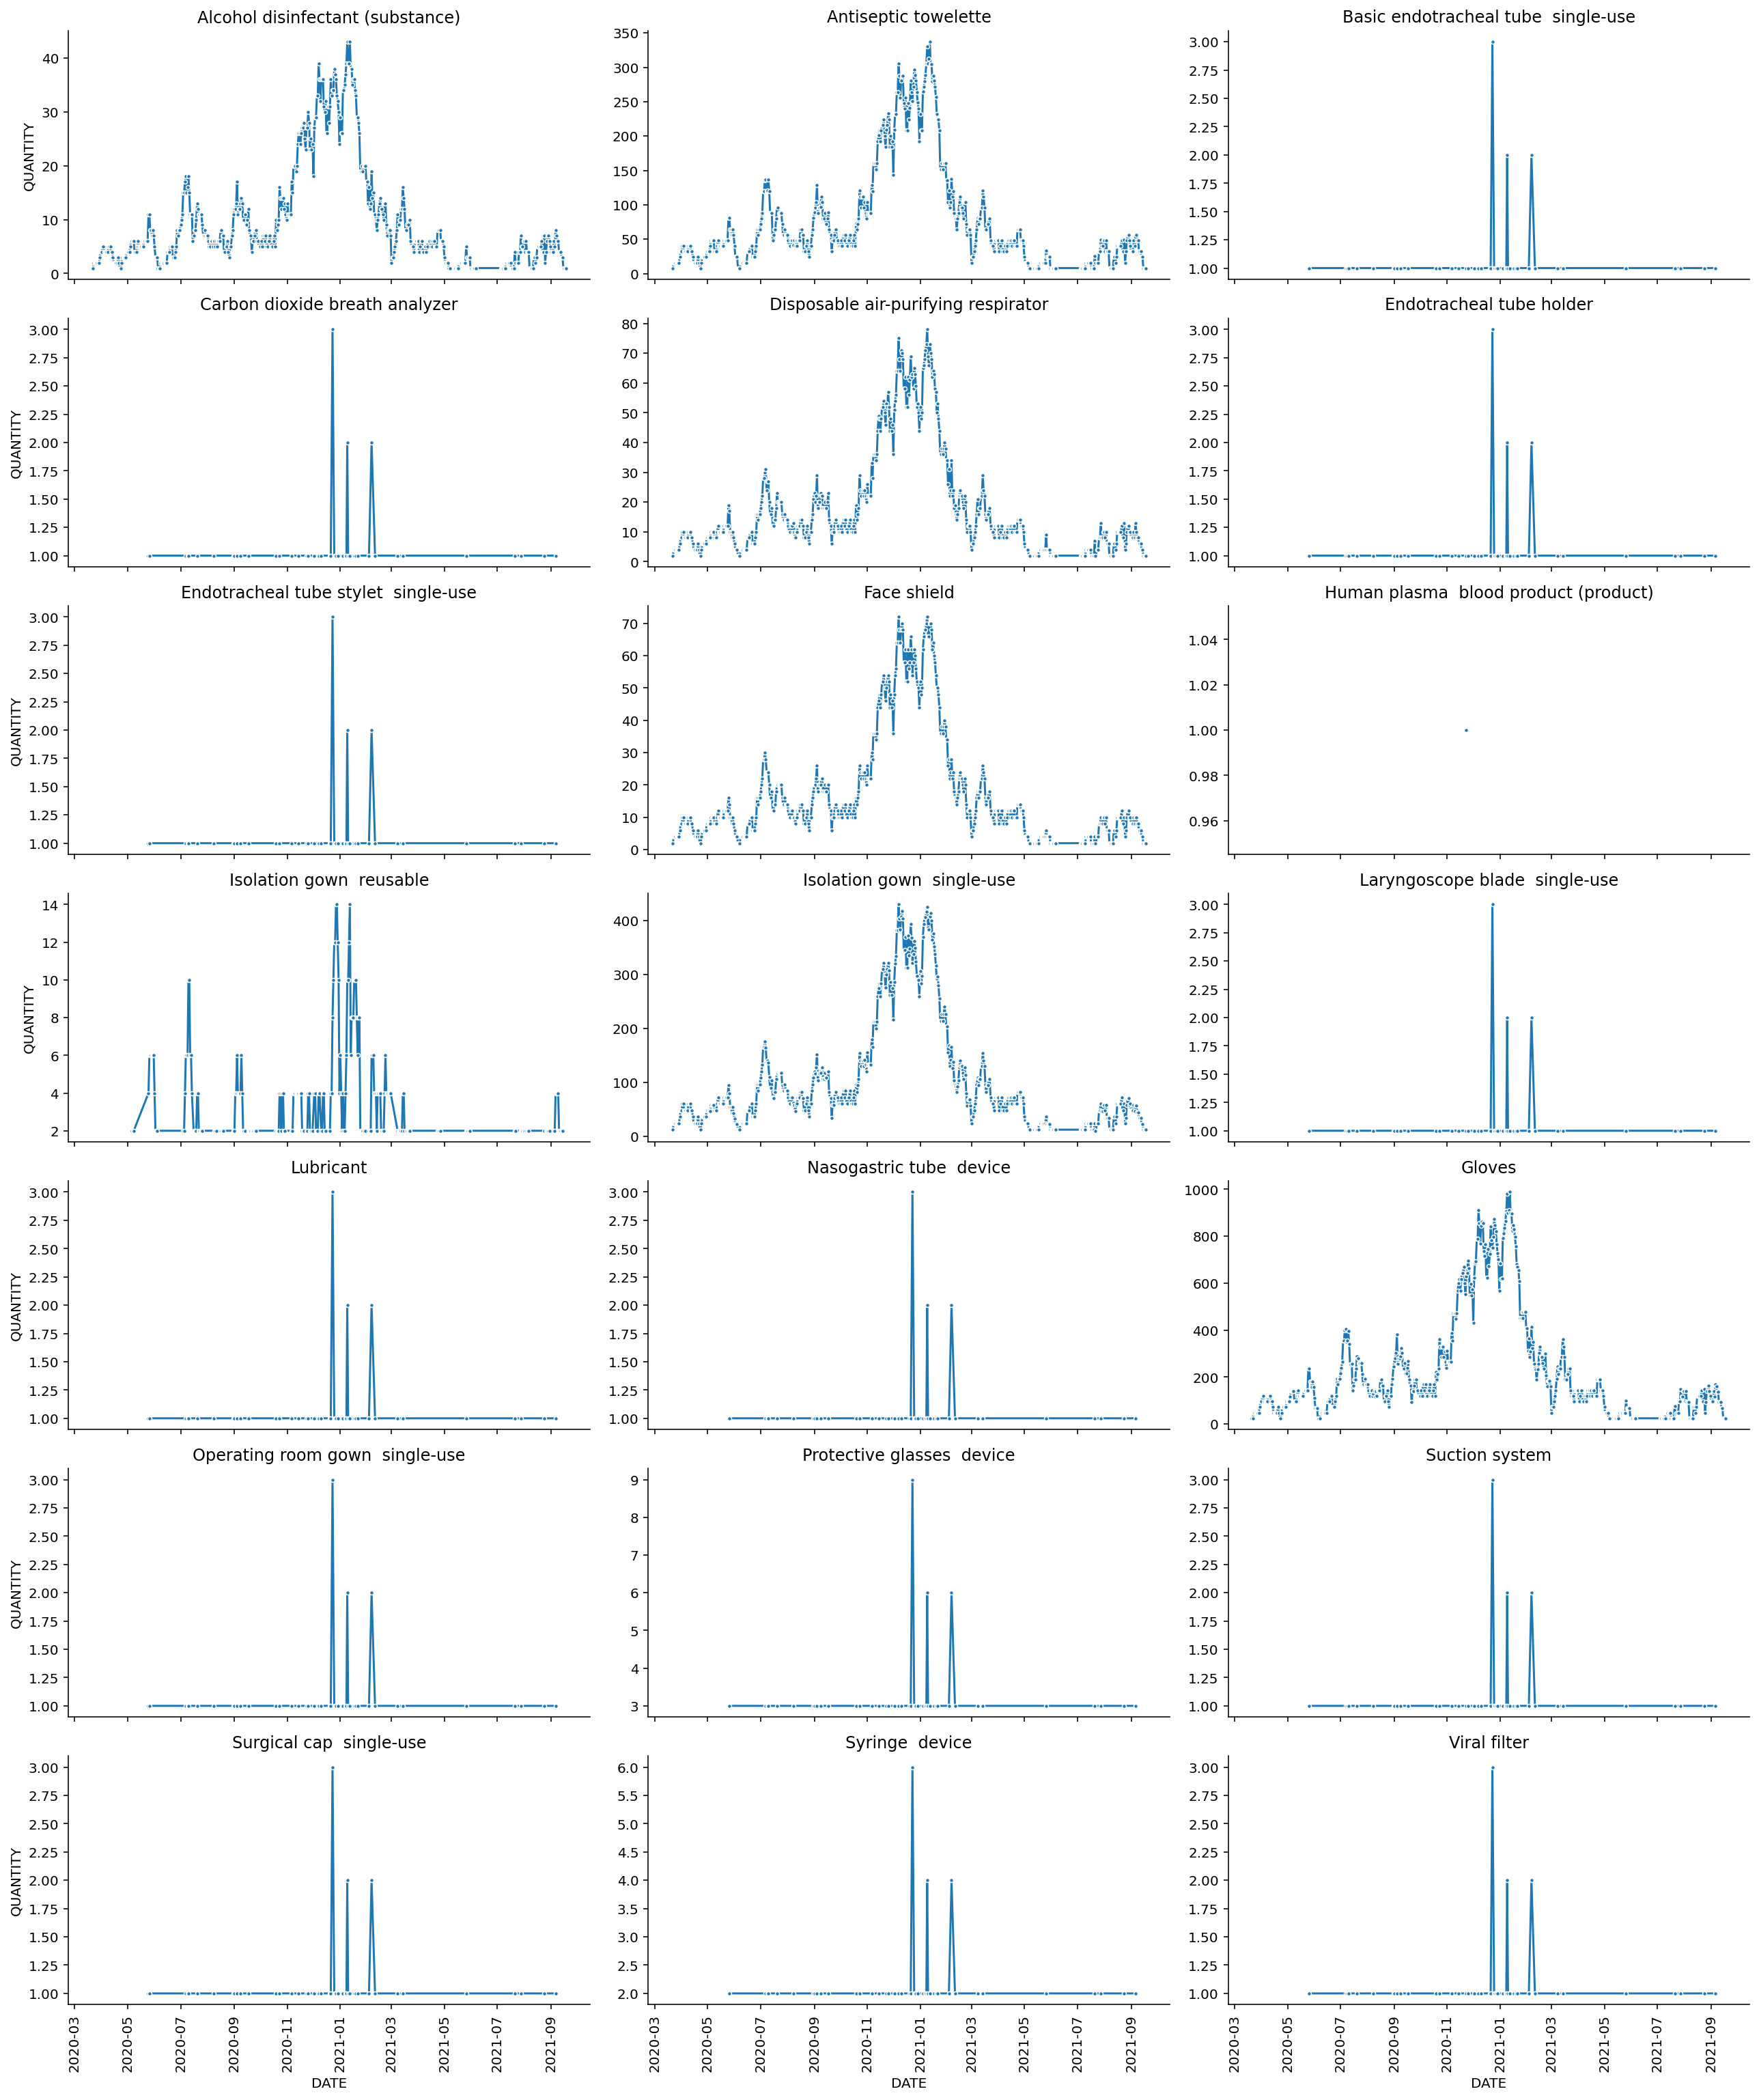

In [48]:
gs = grouped_supplies.reset_index()
gs['DATE'] = pd.to_datetime(gs.DATE)
g = sns.FacetGrid(gs, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "DATE", "QUANTITY", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    if 'glove' in title:
        axes.set_title('Gloves')
    else:    
        axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)

A table showing total supplies used over the entire simulation

In [49]:
supplies.groupby(['DESCRIPTION']).sum()[['QUANTITY']]

,QUANTITY
DESCRIPTION,
Alcohol disinfectant (substance),5116
Antiseptic towelette (physical object),40571
Basic endotracheal tube single-use (physical object),51
Carbon dioxide breath analyzer (physical object),51
Disposable air-purifying respirator (physical object),9419
Endotracheal tube holder (physical object),51
Endotracheal tube stylet single-use (physical object),51
Face shield (physical object),9266
Human plasma blood product (product),1


Build a DataFrame that has cumulative case counts over time

In [50]:
case_counts = conditions[conditions.CODE == 840539006].groupby('START').count()[['PATIENT']]
case_counts['total'] = case_counts['PATIENT'].cumsum()
case_counts = case_counts.rename(columns={'PATIENT': 'daily'})
case_counts = case_counts.reset_index()
case_counts['START'] = pd.to_datetime(case_counts.START)

## Cumulative Case Count

Show total cases over time

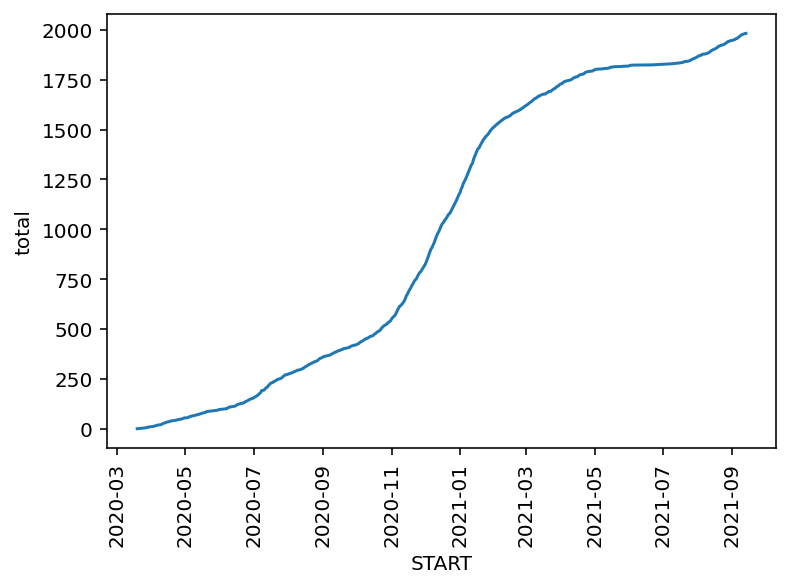

In [51]:
axes = sns.lineplot(x='START', y='total', data=case_counts)
plt.xticks(rotation=90)
plt.show()

## Medication Dispenses

This table shows medications dispensed to patients with COVID-19 since January 20, 2020.

In [52]:
covid_meds = medications[pd.to_datetime(medications.START) > pd.to_datetime('2020-01-20', utc=True)]
covid_meds = covid_info.merge(covid_meds, on='PATIENT')

In [53]:
covid_meds.groupby(['DESCRIPTION']).sum()[['DISPENSES']].sort_values('DISPENSES', ascending=False).head(10)

,DISPENSES
DESCRIPTION,
lisinopril 10 MG Oral Tablet,134678
amLODIPine 2.5 MG Oral Tablet,105599
NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler,48284
Hydrochlorothiazide 25 MG Oral Tablet,3735
Simvastatin 10 MG Oral Tablet,3532
Acetaminophen 500 MG Oral Tablet,3122
0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe,3109
losartan potassium 25 MG Oral Tablet,1773
120 ACTUAT Fluticasone propionate 0.044 MG/ACTUAT Metered Dose Inhaler,1427


## Hospital Day Stats

For patients with COVID-19, calculate the average hospital length of stay as well as total hospital days for all COVID-19 patients. Provide the same information for ICU patients

In [54]:
covid_hosp = analysis.create_covid_hosp(covid_info, encounters, {'admit': True}).reset_index()
covid_icu = analysis.create_covid_icu(covid_info, encounters)
pd.DataFrame.from_records([
    {
        'type': 'inpatient',
        'patients': covid_hosp.PATIENT.nunique(),
        'average stay': ((covid_hosp.STOP - covid_hosp.START) / np.timedelta64(1, 'D')).mean(),
        'total days': ((covid_hosp.STOP - covid_hosp.START) / np.timedelta64(1, 'D')).sum(),
    },
    {
        'type': 'ICU',
        'patients': covid_icu.PATIENT.nunique(),
        'average stay': ((pd.to_datetime(covid_icu.STOP) - pd.to_datetime(covid_icu.START, utc=True)) / np.timedelta64(1, 'D')).mean(),
        'total days': ((pd.to_datetime(covid_icu.STOP) - pd.to_datetime(covid_icu.START, utc=True)) / np.timedelta64(1, 'D')).sum(),
    }
])

,type,patients,average stay,total days
0,inpatient,384,10.980429,4216.484745
1,ICU,70,5.327797,399.584745


In [55]:
device_codes = [448907002, 449071006, 36965003]
grouped_dev = devices[devices.CODE.isin(device_codes)].copy()
grouped_dev['START'] = pd.to_datetime(grouped_dev.START).dt.date
grouped_dev = grouped_dev.groupby(['DESCRIPTION', 'START']).count()
grouped_dev = grouped_dev.reset_index()

## Device Usage

Show the number of devices used to treat COVID-19 over time.

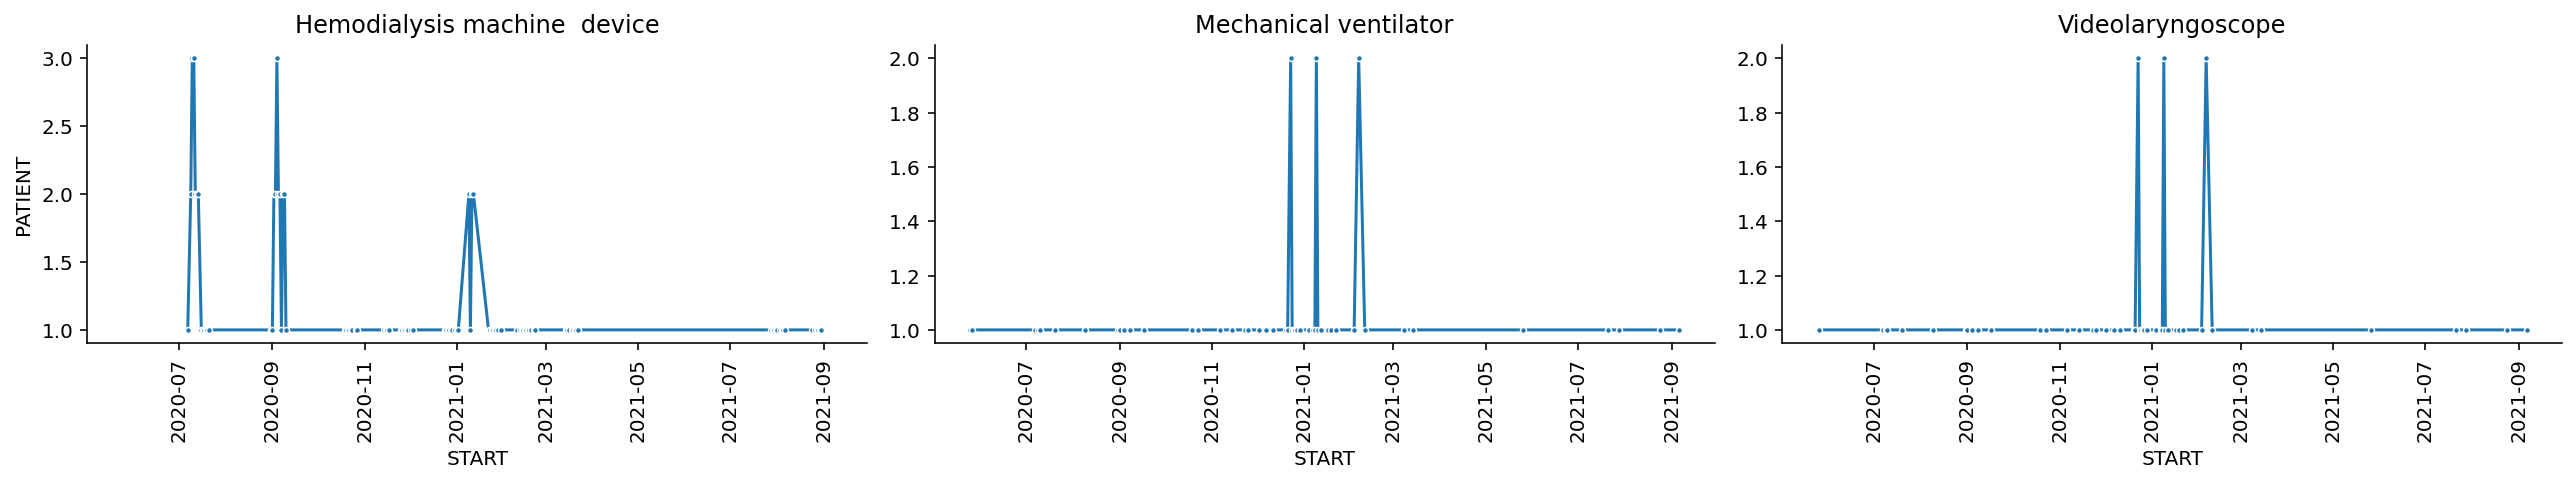

In [56]:
g = sns.FacetGrid(grouped_dev, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "START", "PATIENT", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)

## A Closer Look at Case Counts

Checking the daily case counts

In [57]:
case_counts

,START,daily,total
0,2020-03-19,1,1
1,2020-03-21,1,2
2,2020-03-23,1,3
3,2020-03-24,1,4
4,2020-03-26,1,5
...,...,...,...
447,2021-09-09,4,1974
448,2021-09-10,3,1977
449,2021-09-11,1,1978
450,2021-09-12,3,1981


In [58]:
case_counts.daily.describe()

count    452.000000
mean       4.384956
std        3.783796
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       21.000000
Name: daily, dtype: float64

A line plot of cases per day

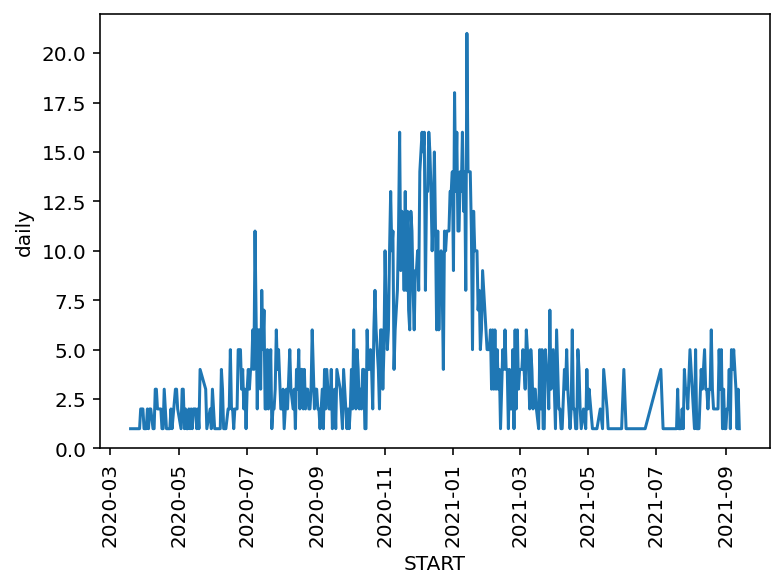

In [59]:
axes = sns.lineplot(x='START', y='daily', data=case_counts)
plt.xticks(rotation=90)
plt.show()

## COVID-19 Immunizations

This section examines COVID-19 immunizations and breakthrough infections.

In [60]:
immunizations['DATE'] = pd.to_datetime(immunizations.DATE).dt.date
covid_immunizations = immunizations[immunizations.CODE.isin([207,208,212])]
shot_counts = covid_immunizations.groupby('DATE').count()[['PATIENT']]
shot_counts['total'] = shot_counts['PATIENT'].cumsum()
shot_counts = shot_counts.rename(columns={'PATIENT': 'daily'})
shot_counts = shot_counts.reset_index()
shot_counts['DATE'] = pd.to_datetime(shot_counts.DATE)

A plot showing total vaccinations per day.

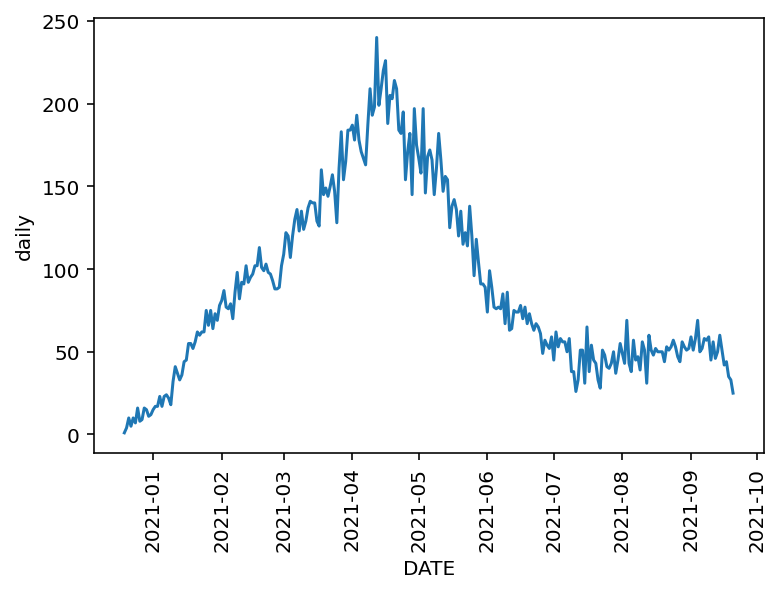

In [61]:
axes = sns.lineplot(x='DATE', y='daily', data=shot_counts)
plt.xticks(rotation=90)
plt.show()

In [62]:
shot_counts.daily.describe()

count    276.000000
mean      89.028986
std       55.016420
min        1.000000
25%       50.000000
50%       71.500000
75%      129.250000
max      240.000000
Name: daily, dtype: float64

In [63]:
patient_immunizations = immunizations.merge(patients, how='left', left_on='PATIENT', right_on='Id')
patient_immunizations['DATE'] = pd.to_datetime(patient_immunizations.DATE)
patient_immunizations['AGE'] = (patient_immunizations.DATE.dt.date - pd.to_datetime(patient_immunizations.BIRTHDATE).dt.date) / np.timedelta64(1, 'Y')
patient_immunizations['AGE_RANGE'] = pd.cut(patient_immunizations.AGE, bins=[0,12,16,18,30,40,50,65,75,120])
cpi = patient_immunizations[patient_immunizations.CODE.isin([207,208,212])]

Looking at the age distribution of those who have received the COVID-19 vaccine

In [64]:
cpi.AGE.describe()

count    24572.000000
mean        48.661024
std         20.722347
min         12.035839
25%         31.526999
50%         49.506835
75%         63.557089
max        110.392411
Name: AGE, dtype: float64

<AxesSubplot:xlabel='AGE', ylabel='Count'>

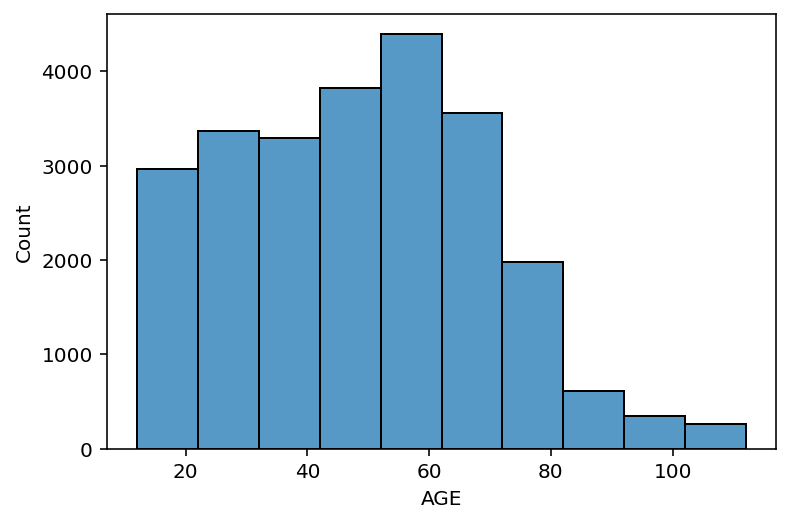

In [65]:
sns.histplot(data=cpi, x="AGE", binwidth=10)

Shots per day by age range

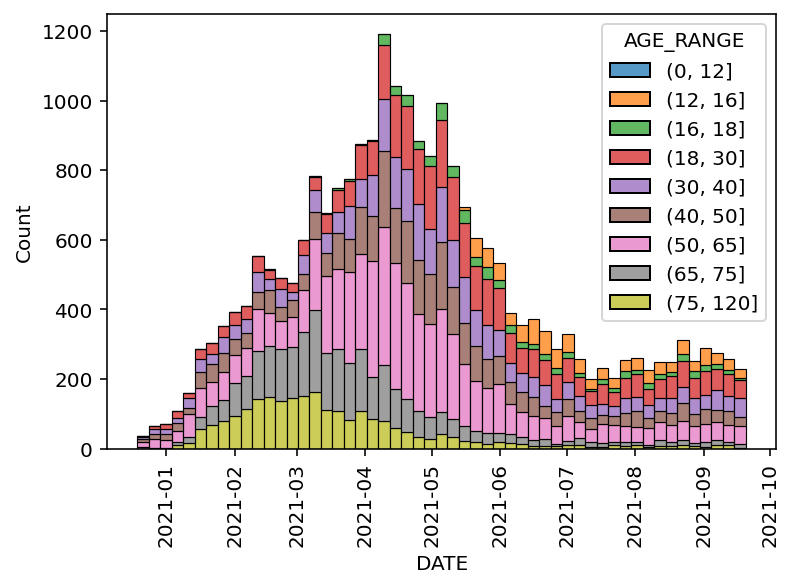

In [66]:
ax = sns.histplot(data=cpi, x="DATE", hue='AGE_RANGE',  multiple="stack")
ax.tick_params(axis='x', rotation=90)

In [67]:
first_covid_shot = covid_immunizations.groupby(['PATIENT'], as_index=False)['DATE'].first()
possible_break_through = first_covid_shot.merge(conditions[conditions.CODE == 840539006], how='inner', on='PATIENT')

Print out the percentage of individuals, who were alive at the end of the simulation and had at least one shot, by age range

In [68]:
patients_with_shot_indicator = patients.merge(first_covid_shot, left_on='Id', right_on='PATIENT', how='left', indicator=True)
patients_with_shot_indicator['AGE'] = (datetime.date.today() - pd.to_datetime(patients_with_shot_indicator.BIRTHDATE).dt.date) / np.timedelta64(1, 'Y')
patients_with_shot_indicator['AGE_RANGE'] = pd.cut(patients_with_shot_indicator.AGE, bins=[0,12,16,18,30,40,50,65,75,120])
alive_wsi = patients_with_shot_indicator[patients_with_shot_indicator.DEATHDATE.isna()]
percent_vaxed = alive_wsi.groupby(['AGE_RANGE', '_merge']).size().unstack()
percent_vaxed.both / (percent_vaxed.both + percent_vaxed.left_only)

AGE_RANGE
(0, 12]      0.000000
(12, 16]     0.528380
(16, 18]     0.616667
(18, 30]     0.593264
(30, 40]     0.699564
(40, 50]     0.745557
(50, 65]     0.808981
(65, 75]     0.942744
(75, 120]    0.914431
dtype: float64

Display a chart showing cases and breakthrough cases. The chart starts in December of 2020, since that is when people were first vaccinated and is when there is an actual chance of breakthrough infections.

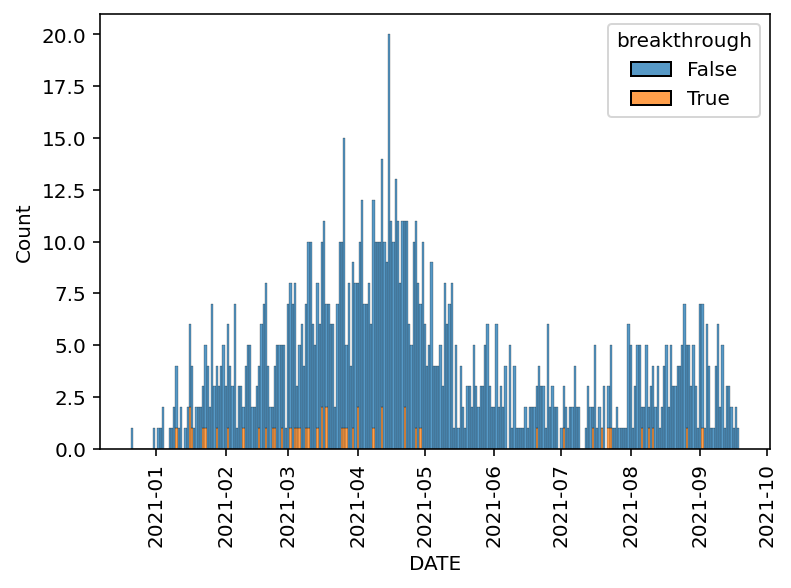

In [69]:
possible_break_through['breakthrough'] = possible_break_through.DATE < pd.to_datetime(possible_break_through.START).dt.date
ax = sns.histplot(data=possible_break_through, x="DATE", hue='breakthrough',  multiple="stack")
ax.tick_params(axis='x', rotation=90)

In [70]:
start_date = datetime.date(2020, 12, 10)
end_date = datetime.date(2021, 9, 8)

vax_stats = []

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

for single_date in daterange(start_date, end_date):
    alive_count = patients[(pd.to_datetime(patients.BIRTHDATE).dt.date <= single_date) & (patients.DEATHDATE.isna() | (pd.to_datetime(patients.DEATHDATE).dt.date > single_date))].shape[0]
    alive_vaccinated = cpi[(pd.to_datetime(cpi.DATE).dt.date <= single_date) & (pd.to_datetime(cpi.BIRTHDATE).dt.date <= single_date) & (cpi.DEATHDATE.isna() | (pd.to_datetime(cpi.DEATHDATE).dt.date > single_date))].PATIENT.nunique()
    vax_stats.append({'date': single_date, 'alive_count': alive_count, 'alive_vaccinated': alive_vaccinated})
    
pop_vax_stats = pd.DataFrame.from_records(vax_stats)

In [71]:
pop_vax_stats['percentage'] = pop_vax_stats.alive_vaccinated / pop_vax_stats.alive_count

Display a chart showing the percentage of people who are alive at the time in the simulation who have had at least one shot

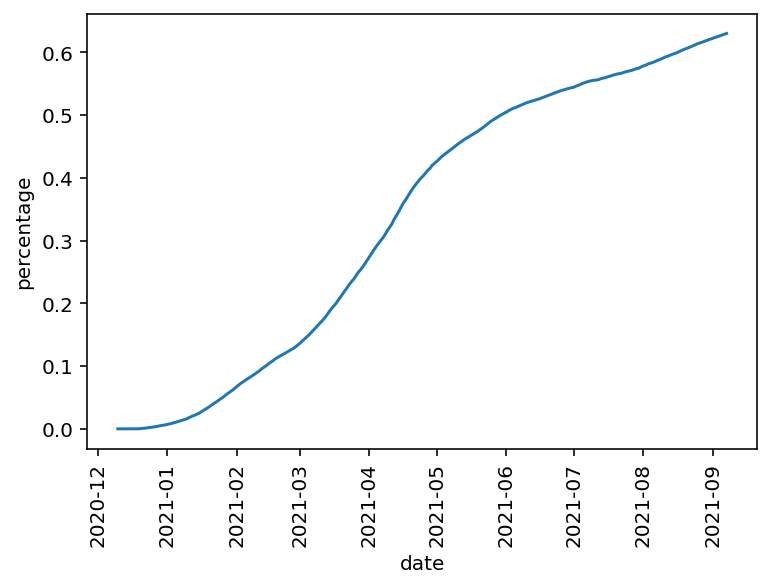

In [72]:
ax = sns.lineplot(data=pop_vax_stats, x='date', y='percentage')
ax.tick_params(axis='x', rotation=90)

The following plot shows case counts overlayed by vaccinations. Case counts are in blue on the left y-axis while vaccinations are in red on the right y-axis.

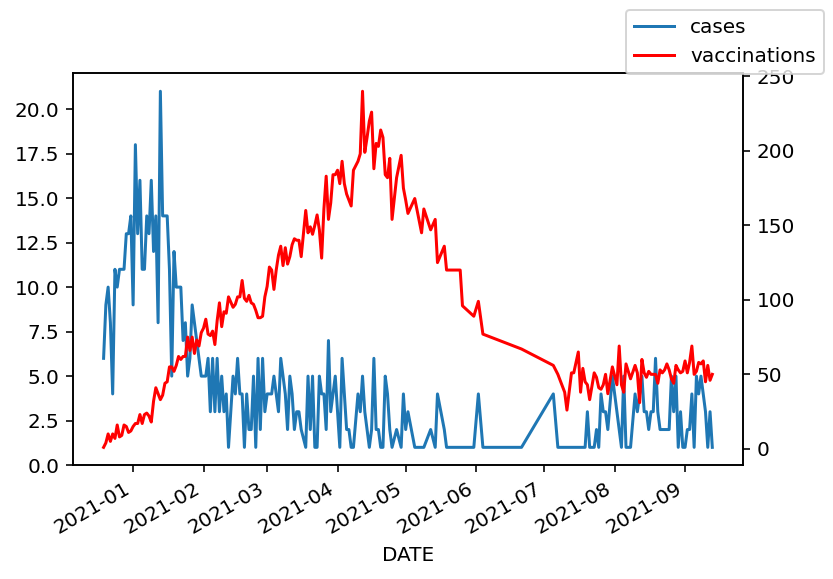

In [73]:
vaccination_days = shot_counts.rename(columns={'daily': 'vaccinations'})[['DATE', 'vaccinations']]
case_days = case_counts.rename(columns={'daily': 'cases', 'START': 'DATE'})[['DATE', 'cases']]
cases_and_shots = case_days.merge(vaccination_days, on="DATE")
ax = cases_and_shots.plot(x="DATE", y="cases", legend=False)
ax2 = ax.twinx()
cases_and_shots.plot(x="DATE", y="vaccinations", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.xticks(rotation=90)
plt.show()